<a href="https://colab.research.google.com/github/sbarrios93/35200-Deep-Learning-Systems/blob/main/Assignment%204%3A%20Benchmark%20different%20platforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this assignment, you will experiment with running a DNN and measuring its performance with Colab GPU & ThetaGPU.

We provide both Pytorch & TF2.0 snippets for you to start with. 

You should implement the JAX version using [haiku](https://github.com/deepmind/dm-haiku) or [flax](https://github.com/google/flax). Since JAX doesn't handle dataloading, you can use either pytorch loader or tensorflow loader.

\* Based on assignment-1 notebook, adapted from ["PyTorch 1.2 Quickstart with Google Colab"](https://colab.research.google.com/github/omarsar/pytorch_notebooks/blob/master/pytorch_quick_start.ipynb) and ["Tensorflow 2.0 Quickstart for experts"](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb#scrollTo=DUNzJc4jTj6G)

# PyTorch version

In [1]:
!pip3 install torch torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
print(torch.__version__)

if torch.cuda.is_available():
    !nvidia-smi

1.9.0+cu111
Sat Oct 23 05:34:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                            

## Import The Data `torch.utils.data.Dataloader`
The first step before training the model is to import the data. We will use the [CIFAR100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) which is like the Hello World dataset of machine learning. 

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models. 
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. We encourage you to experiment with different batches.

In [4]:
BATCH_SIZE = 32
EPOCHS = 15

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

## download and load training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2, pin_memory=True)

## download and load testing dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


## Exploring the Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
Image batch dimensions: torch.Size([32, 3, 32, 32])
Image label dimensions: torch.Size([32])


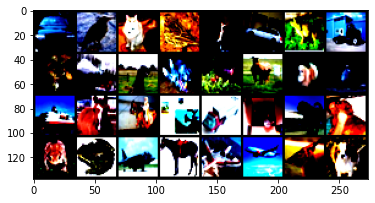

In [5]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(type(images))
## show images
imshow(torchvision.utils.make_grid(images))

## check dimensions of a batch
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

## The Model
Now using the classical deep learning framework pipeline, let's build the 1 convolutional layer model. 

Here are a few notes for those who are beginning with PyTorch:
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have a convolutional layer denoted by `nn.Conv2d(...)`. We are dealing with an image dataset that is in a grayscale so we only need one channel going in, hence `in_channels=1`. We hope to get a nice representation of this layer, so we use `out_channels=32`. Kernel size is 3, and for the rest of parameters we use the default values which you can find [here](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d). 
- We use 2 back to back dense layers or what we refer to as linear transformations to the incoming data. Notice for `d1` I have a dimension which looks like it came out of nowhere. 128 represents the size we want as output and the (`26*26*32`) represents the dimension of the incoming data. If you would like to find out how to calculate those numbers refer to the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html?highlight=linear#conv2d). In short, the convolutional layer transforms the input data into a specific dimension that has to be considered in the linear layer. The same applies for the second linear transformation (`d2`) where the dimension of the output of the previous linear layer was added as `in_features=128`, and `10` is just the size of the output which also corresponds to the number of classes.
- After each one of those layers, we also apply an activation function such as `ReLU`. For prediction purposes, we then apply a `softmax` layer to the last transformation and return the output of that.  

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [7]:
model = LeNet()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Training the model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model. 

In [8]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [9]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [10]:
%%time 
from tqdm import tqdm

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for epoch in range(EPOCHS):
    train_running_loss = 0.0
    train_acc = 0.0
    valid_running_loss = 0.0
    valid_acc = 0.0

    model = model.train()

    ## training step
    for images, labels in tqdm(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Train Loss: %.4f | Train Accuracy: %.4f' \
          %(epoch, train_running_loss / len(trainloader), train_acc / len(trainloader)))

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 1563/1563 [00:15<00:00, 103.27it/s]


Epoch: 0 | Train Loss: 1.5476 | Train Accuracy: 43.4061


100%|██████████| 1563/1563 [00:15<00:00, 103.04it/s]


Epoch: 1 | Train Loss: 1.2765 | Train Accuracy: 54.2886


100%|██████████| 1563/1563 [00:15<00:00, 103.92it/s]


Epoch: 2 | Train Loss: 1.1717 | Train Accuracy: 58.2494


100%|██████████| 1563/1563 [00:15<00:00, 103.37it/s]


Epoch: 3 | Train Loss: 1.1016 | Train Accuracy: 60.9065


100%|██████████| 1563/1563 [00:15<00:00, 103.24it/s]


Epoch: 4 | Train Loss: 1.0436 | Train Accuracy: 62.9139


100%|██████████| 1563/1563 [00:15<00:00, 103.44it/s]


Epoch: 5 | Train Loss: 1.0054 | Train Accuracy: 64.4554


100%|██████████| 1563/1563 [00:15<00:00, 103.28it/s]


Epoch: 6 | Train Loss: 0.9729 | Train Accuracy: 65.4651


100%|██████████| 1563/1563 [00:15<00:00, 103.42it/s]


Epoch: 7 | Train Loss: 0.9404 | Train Accuracy: 66.6847


100%|██████████| 1563/1563 [00:15<00:00, 102.80it/s]


Epoch: 8 | Train Loss: 0.9145 | Train Accuracy: 67.4124


100%|██████████| 1563/1563 [00:15<00:00, 103.48it/s]


Epoch: 9 | Train Loss: 0.8926 | Train Accuracy: 68.3161


100%|██████████| 1563/1563 [00:15<00:00, 100.23it/s]


Epoch: 10 | Train Loss: 0.8745 | Train Accuracy: 68.9859


100%|██████████| 1563/1563 [00:15<00:00, 102.92it/s]


Epoch: 11 | Train Loss: 0.8585 | Train Accuracy: 69.4758


100%|██████████| 1563/1563 [00:15<00:00, 102.15it/s]


Epoch: 12 | Train Loss: 0.8458 | Train Accuracy: 70.1476


100%|██████████| 1563/1563 [00:15<00:00, 102.99it/s]


Epoch: 13 | Train Loss: 0.8322 | Train Accuracy: 70.4035


100%|██████████| 1563/1563 [00:15<00:00, 103.01it/s]

Epoch: 14 | Train Loss: 0.8207 | Train Accuracy: 70.9593
CPU times: user 1min 58s, sys: 12.9 s, total: 2min 11s
Wall time: 3min 47s


## Testing the model

In [11]:
test_acc = 0.0

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        test_acc += get_accuracy(logits, labels, BATCH_SIZE)
print('Test Accuracy: %.4f'%(test_acc / len(testloader)))

Test Accuracy: 64.7165


## Benchmark performance

### Colab stats

- GPU model: NVIDIA P100 16GB

- Accuracy:\
  - Train: 70.95%
  - Test: 64.72%
- Loss:\
  - Train: 0.8207  

- How long did it take to train? (use `%%time` to measure)\
  - Wall Time: 3min 47sec

### A100 (thetagpu) stats

- Accuracy:\
  - Train: 71.40%
  - Test: 66.33%
- Loss:\
  - Train: 0.8076  

- How long did it take to train? (use `%%time` to measure)\
  - Wall Time: 1min 22 sec

# Tensorflow 2 version

In [12]:
!pip3 install tensorflow tensorflow-datasets==4.0.1 tensorflow_addons==0.14

In [13]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [14]:
print(tf.__version__)

if tf.config.list_physical_devices('GPU'):
    !nvidia-smi

2.6.0
Sat Oct 23 05:38:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |   1031MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-

## Import The Data `tf.data.Dataset`
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which is like the Hello World dataset of machine learning. 

Besides importing the data, we will also do a few more things:
- We will cast the data into float32 tensors
- We will use `tf.data.Dataset` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models. 
- similar to PyTorch, Tensorflow 2.0 Dataset API also provides convenient transformation and batching options, in a chaining style. We encourage you to experiment with different batches.

In [15]:
import tensorflow.image as transforms
import tensorflow_addons as tfa

cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

Use `tf.data` to batch and shuffle the dataset:

In [16]:
BATCH_SIZE = 32
EPOCHS = 15

def transform_train(image, label):
    image = transforms.resize(image, (32, 32))
    image = transforms.random_flip_left_right(image)
    image = transforms.per_image_standardization(image)
    return image, label

def transform(image, label):
    image = transforms.resize(image, (32, 32))
    image = transforms.per_image_standardization(image)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).map(transform_train).shuffle(10000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(transform).batch(BATCH_SIZE)

## Exploring the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 32, 3)
Image batch dimensions: (32, 32, 32, 3)
Image label dimensions: (32, 1)


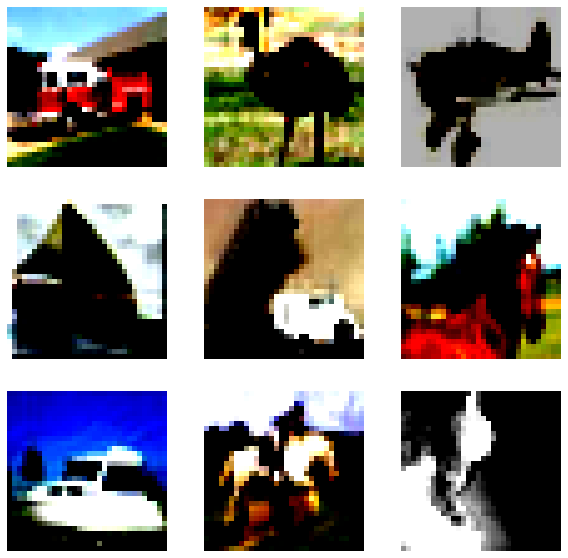

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze()) # https://stackoverflow.com/a/59601192
        plt.axis("off")

## check dimensions of a batch
for images, labels in train_ds:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

## The Model
Now using the classical deep learning framework pipeline, let's build the 1 convolutional layer model. 

Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras#model_subclassing):
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have a convolutional layer denoted by `tf.keras.Conv2D(...)`. Keras infers the input dimension by itself, and we hope to get a nice representation of this layer, so we use `filters=32`. Kernel size is 3, and for the rest of parameters we use the default values which you can find [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D). 
- We use 2 back to back dense layers or what we refer to as linear transformations to the incoming data. Keras infers the dimension of input by itself. For layer parameter math, please refer to the corresponding PyTorch block above and the [TF2 Keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) for details. 
- Activation functions is configured within layer calls.

In [26]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D
from tensorflow.keras import Model

class LeNet(Model):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = Conv2D(6, 5, activation='relu')
    self.conv2 = Conv2D(16, 5, activation='relu')
    self.flatten = Flatten()
    self.maxpool = MaxPool2D((2,2), 2)
    self.fc1 = Dense(120, activation='relu')
    self.fc2 = Dense(84, activation='relu')
    self.fc2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [27]:
# Create an instance of the model
model = LeNet()

## Training the model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model. 

Choose an optimizer and loss function for training: 

In [28]:
learning_rate = 0.001
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
scheduler = tf.keras.optimizers.schedules.CosineDecay(
    learning_rate, EPOCHS, alpha=0.0
)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [29]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Use `tf.GradientTape` to train the model:

In [30]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [31]:
%%time

from tqdm import tqdm

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in tqdm(train_ds):
    train_step(images, labels)

  print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
        %(epoch, train_loss.result(), train_accuracy.result() * 100))

100%|██████████| 1563/1563 [00:07<00:00, 210.17it/s]


Epoch: 0 | Loss: 1.4948 | Train Accuracy: 45.68


100%|██████████| 1563/1563 [00:06<00:00, 228.57it/s]


Epoch: 1 | Loss: 1.2159 | Train Accuracy: 56.75


100%|██████████| 1563/1563 [00:06<00:00, 224.23it/s]


Epoch: 2 | Loss: 1.1073 | Train Accuracy: 61.10


100%|██████████| 1563/1563 [00:06<00:00, 232.64it/s]


Epoch: 3 | Loss: 1.0429 | Train Accuracy: 63.45


100%|██████████| 1563/1563 [00:06<00:00, 229.93it/s]


Epoch: 4 | Loss: 0.9975 | Train Accuracy: 64.85


100%|██████████| 1563/1563 [00:06<00:00, 229.26it/s]


Epoch: 5 | Loss: 0.9616 | Train Accuracy: 66.13


100%|██████████| 1563/1563 [00:06<00:00, 225.89it/s]


Epoch: 6 | Loss: 0.9337 | Train Accuracy: 67.42


100%|██████████| 1563/1563 [00:06<00:00, 228.81it/s]


Epoch: 7 | Loss: 0.9081 | Train Accuracy: 68.09


100%|██████████| 1563/1563 [00:06<00:00, 234.54it/s]


Epoch: 8 | Loss: 0.8867 | Train Accuracy: 68.96


100%|██████████| 1563/1563 [00:06<00:00, 234.06it/s]


Epoch: 9 | Loss: 0.8659 | Train Accuracy: 69.70


100%|██████████| 1563/1563 [00:06<00:00, 232.65it/s]


Epoch: 10 | Loss: 0.8500 | Train Accuracy: 70.25


100%|██████████| 1563/1563 [00:06<00:00, 227.17it/s]


Epoch: 11 | Loss: 0.8335 | Train Accuracy: 70.79


100%|██████████| 1563/1563 [00:06<00:00, 229.75it/s]


Epoch: 12 | Loss: 0.8190 | Train Accuracy: 71.40


100%|██████████| 1563/1563 [00:06<00:00, 231.63it/s]


Epoch: 13 | Loss: 0.8109 | Train Accuracy: 71.65


100%|██████████| 1563/1563 [00:06<00:00, 231.89it/s]

Epoch: 14 | Loss: 0.7939 | Train Accuracy: 72.12
CPU times: user 2min 15s, sys: 10.3 s, total: 2min 26s
Wall time: 1min 42s


## Testing the model

In [32]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [25]:
for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

print(f'Test Accuracy: {test_accuracy.result() * 100:.2f}')

Test Accuracy: 64.90


## Benchmark performance

### Colab stats

- GPU model: [find out by 'nvidia-smi']

- Accuracy:\
  - Train: 72.12%
  - Test: 64.9%
- Loss:\
  - Train: 0.7939  

- How long did it take to train? (use `%%time` to measure)\
  - Wall Time: 1min 42 sec

### A100 (thetagpu) stats

- Accuracy:\
  - Train: 72.56%
  - Test: 67.29%
- Loss:\
  - Train: 0.7809  

- How long did it take to train? (use `%%time` to measure)\
  - Wall Time: 1min 4 sec

# JAX version
Use [haiku](https://github.com/deepmind/dm-haiku) or [flax](https://github.com/google/flax) as the high level interface for JAX neural network implementation.

## Import The Data
Jax doesn't handle data loading, you can use Pytorch, Tensorflow dataset or devise your own loader.

## Exploring the Data

## The Model

## Training the model

## Testing the model

## Benchmark performance

### Colab stats

- GPU model: [find out by 'nvidia-smi']

- Accuracy:\
 [click to edit] >< [+/- how much % compared with baseline]

- Loss:\
 [click to edit] >< [+/- how much % compared with baseline]

- How long did it take to train? (use `%%time` to measure)\
 [click to edit]

### A100 (thetagpu) stats

- Accuracy:\
 [click to edit] >< [+/- how much % compared with baseline]

- Loss:\
 [click to edit] >< [+/- how much % compared with baseline]

- How long did it take to train? (use `%%time` to measure)\
 [click to edit]

# Summary your findings here

Briefly summarize what you have learned from this exercise in a paragraph or two.

[click to edit]